In [1]:
# Data I/O and preprocessing
import numpy as np

# System
import time
import os
import gc
import graphviz

# Graphic
import matplotlib.pyplot as plt

from tqdm import tqdm

%matplotlib inline

In [2]:
# directory
icecube_dir = "C:/Users/chris/Desktop/Research/icecube-neutrinos-in-deep-ice"
model_dir = "C:/Users/chris/Desktop/Research/icecube-neutrinos-in-deep-ice/icecubemodels"
data_dir = "C:/Users/chris/Desktop/Research"

In [3]:
# data
bin_num = 16

train_batch_id_min = 100
train_batch_id_max = 110

train_batch_ids = train_batch_id_max - train_batch_id_min # range(train_batch_id_min, train_batch_id_max + 1)

# model
LSTM_width = 192

# training
validation_split = 0.05
seed = 42
epochs = 20
batch_size = 512
fit_verbose = 1

In [4]:
# data preprocessing
point_picker_format = data_dir + '/pp_mpc96_n6_batch_{batch_id:d}.npz'

# model
model_output_path = "./" + "PointPicker_mpc96bin16_LSTM160DENSE0"

# Prepare Metric

## Scoring functions

In [5]:
def angular_dist_score(az_true, zen_true, az_pred, zen_pred):
    '''
    calculate the MAE of the angular distance between two directions.
    The two vectors are first converted to cartesian unit vectors,
    and then their scalar product is computed, which is equal to
    the cosine of the angle between the two vectors. The inverse 
    cosine (arccos) thereof is then the angle between the two input vectors
    
    Parameters:
    -----------
    
    az_true : float (or array thereof)
        true azimuth value(s) in radian
    zen_true : float (or array thereof)
        true zenith value(s) in radian
    az_pred : float (or array thereof)
        predicted azimuth value(s) in radian
    zen_pred : float (or array thereof)
        predicted zenith value(s) in radian
    
    Returns:
    --------
    
    dist : float
        mean over the angular distance(s) in radian
    '''
    
    if not (np.all(np.isfinite(az_true)) and
            np.all(np.isfinite(zen_true)) and
            np.all(np.isfinite(az_pred)) and
            np.all(np.isfinite(zen_pred))):
        raise ValueError("All arguments must be finite")
    
    # pre-compute all sine and cosine values
    sa1 = np.sin(az_true)
    ca1 = np.cos(az_true)
    sz1 = np.sin(zen_true)
    cz1 = np.cos(zen_true)
    
    sa2 = np.sin(az_pred)
    ca2 = np.cos(az_pred)
    sz2 = np.sin(zen_pred)
    cz2 = np.cos(zen_pred)
    
    # scalar product of the two cartesian vectors (x = sz*ca, y = sz*sa, z = cz)
    scalar_prod = sz1*sz2*(ca1*ca2 + sa1*sa2) + (cz1*cz2)
    
    # scalar product of two unit vectors is always between -1 and 1, this is against nummerical instability
    # that might otherwise occure from the finite precision of the sine and cosine functions
    scalar_prod =  np.clip(scalar_prod, -1, 1)
    
    # convert back to an angle (in radian)
    return np.average(np.abs(np.arccos(scalar_prod)))

## Angle One-hot Encoding

- azimuth and zenith are independent
- azimuth distribution is flat and zenith distribution is sin
  - Flat on the spherical surface
  - $\phi > \pi$ events are a little bit rarer than $\phi < \pi$ events, (maybe) because of the neutrino attenuation by earth.
- So, the uniform bin is used for azimuth, and $\left| \cos \right|$ bin is used for zenith

In [6]:
azimuth_edges = np.linspace(0, 2 * np.pi, bin_num + 1)
zenith_edges_flat = np.linspace(0, np.pi, bin_num + 1)
zenith_edges = list()
zenith_edges.append(0)
for bin_idx in range(1, bin_num):
    # cos(zen_before) - cos(zen_now) = 2 / bin_num
    zen_now = np.arccos(np.cos(zenith_edges[-1]) - 2 / (bin_num))
    zenith_edges.append(zen_now)
zenith_edges.append(np.pi)
zenith_edges = np.array(zenith_edges)

In [7]:
def y_to_onehot(batch_y):
    # evaluate bin code
    azimuth_code = (batch_y[:, 0] > azimuth_edges[1:].reshape((-1, 1))).sum(axis=0)
    zenith_code = (batch_y[:, 1] > zenith_edges[1:].reshape((-1, 1))).sum(axis=0)
    angle_code = bin_num * azimuth_code + zenith_code

    # one-hot
    batch_y_onehot = np.zeros((angle_code.size, bin_num * bin_num))
    batch_y_onehot[np.arange(angle_code.size), angle_code] = 1
    
    return batch_y_onehot

## Define a function converts from prediction to angles

- Calculation of the mean-vector in a bin $\theta \in ( \theta_0, \theta_1 )$ and $\phi \in ( \phi_0, \phi_1 )$
  - $\vec{r} \left( \theta, ~ \phi \right) = \left< \sin \theta \cos \phi, ~ \sin \theta \sin \phi, ~ \cos \theta \right>$
  - $\bar{\vec{r}} = \frac{ \int_{\theta_{0}}^{\theta_{1}} \int_{\phi_0}^{\phi_1} \vec{r} \left( \theta, ~ \phi \right) \sin \theta \,d\phi \,d\theta }{ \int_{\theta_{0}}^{\theta_{1}} \int_{\phi_0}^{\phi_1} 1 \sin \theta \,d\phi \,d\theta }$
  - $ \int_{\theta_{0}}^{\theta_{1}} \int_{\phi_0}^{\phi_1} 1 \sin \theta \,d\phi \,d\theta = \left( \phi_1 - \phi_0 \right) \left( \cos \theta_0 - \cos \theta_1 \right)$
  - $
\int_{\theta_{0}}^{\theta_{1}} \int_{\phi_0}^{\phi_1} {r}_{x} \left( \theta, ~ \phi \right) \sin \theta \,d\phi \,d\theta = 
\int_{\theta_{0}}^{\theta_{1}} \int_{\phi_0}^{\phi_1} \sin^2 \theta \cos \phi \,d\phi \,d\theta = 
\left( \sin \phi_1 - \sin \phi_0 \right) \left( \frac{\theta_1 - \theta_0}{2} - \frac{\sin 2 \theta_1 - \sin 2 \theta_0}{4} \right)
$
  - $
\int_{\theta_{0}}^{\theta_{1}} \int_{\phi_0}^{\phi_1} {r}_{y} \left( \theta, ~ \phi \right) \sin \theta \,d\phi \,d\theta = 
\int_{\theta_{0}}^{\theta_{1}} \int_{\phi_0}^{\phi_1} \sin^2 \theta \sin \phi \,d\phi \,d\theta = 
\left( \cos \phi_0 - \cos \phi_1 \right) \left( \frac{\theta_1 - \theta_0}{2} - \frac{\sin 2 \theta_1 - \sin 2 \theta_0}{4} \right)
$
  - $
\int_{\theta_{0}}^{\theta_{1}} \int_{\phi_0}^{\phi_1} {r}_{z} \left( \theta, ~ \phi \right) \sin \theta \,d\phi \,d\theta = 
\int_{\theta_{0}}^{\theta_{1}} \int_{\phi_0}^{\phi_1} \sin \theta \cos \theta \,d\phi \,d\theta = 
\left( \phi_1 - \phi_0 \right) \left( \frac{\cos 2 \theta_0 - \cos 2 \theta_1}{4} \right)
$

In [8]:
angle_bin_zenith0 = np.tile(zenith_edges[:-1], bin_num)
angle_bin_zenith1 = np.tile(zenith_edges[1:], bin_num)
angle_bin_azimuth0 = np.repeat(azimuth_edges[:-1], bin_num)
angle_bin_azimuth1 = np.repeat(azimuth_edges[1:], bin_num)

angle_bin_area = (angle_bin_azimuth1 - angle_bin_azimuth0) * (np.cos(angle_bin_zenith0) - np.cos(angle_bin_zenith1))
angle_bin_vector_sum_x = (np.sin(angle_bin_azimuth1) - np.sin(angle_bin_azimuth0)) * ((angle_bin_zenith1 - angle_bin_zenith0) / 2 - (np.sin(2 * angle_bin_zenith1) - np.sin(2 * angle_bin_zenith0)) / 4)
angle_bin_vector_sum_y = (np.cos(angle_bin_azimuth0) - np.cos(angle_bin_azimuth1)) * ((angle_bin_zenith1 - angle_bin_zenith0) / 2 - (np.sin(2 * angle_bin_zenith1) - np.sin(2 * angle_bin_zenith0)) / 4)
angle_bin_vector_sum_z = (angle_bin_azimuth1 - angle_bin_azimuth0) * ((np.cos(2 * angle_bin_zenith0) - np.cos(2 * angle_bin_zenith1)) / 4)

angle_bin_vector_mean_x = angle_bin_vector_sum_x / angle_bin_area
angle_bin_vector_mean_y = angle_bin_vector_sum_y / angle_bin_area
angle_bin_vector_mean_z = angle_bin_vector_sum_z / angle_bin_area

angle_bin_vector = np.zeros((1, bin_num * bin_num, 3))
angle_bin_vector[:, :, 0] = angle_bin_vector_mean_x
angle_bin_vector[:, :, 1] = angle_bin_vector_mean_y
angle_bin_vector[:, :, 2] = angle_bin_vector_mean_z

In [9]:
def pred_to_angle(pred, epsilon=1e-8):
    # convert prediction to vector
    pred_vector = (pred.reshape((-1, bin_num * bin_num, 1)) * angle_bin_vector).sum(axis=1)
    
    # normalize
    pred_vector_norm = np.sqrt((pred_vector**2).sum(axis=1))
    mask = pred_vector_norm < epsilon
    pred_vector_norm[mask] = 1
    
    # assign <1, 0, 0> to very small vectors (badly predicted)
    pred_vector /= pred_vector_norm.reshape((-1, 1))
    pred_vector[mask] = np.array([1., 0., 0.])
    
    # convert to angle
    azimuth = np.arctan2(pred_vector[:, 1], pred_vector[:, 0])
    azimuth[azimuth < 0] += 2 * np.pi
    zenith = np.arccos(pred_vector[:, 2])
    
    return azimuth, zenith

## Read feature data for training

In [10]:
print("Reading training data...")

train_x = None
train_y = None
for batch_id in tqdm(range(train_batch_id_min, train_batch_id_max + 1)):
    train_data_file = np.load(point_picker_format.format(batch_id=batch_id))
    
    if train_x is None:
        train_x = train_data_file["x"]
        train_y = train_data_file["y"]
    else:
        train_x = np.append(train_x, train_data_file["x"], axis=0)
        train_y = np.append(train_y, train_data_file["y"], axis=0)
        
    train_data_file.close()
    del train_data_file
    _ = gc.collect()

Reading training data...


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:06<00:00,  1.72it/s]


# Data Preprocessing

In [11]:
train_x[:, :, 0] /= 1000  # time
train_x[:, :, 1] /= 300  # charge
train_x[:, :, 3:] /= 600  # space

train_y_onehot = y_to_onehot(train_y)

## Split validation samples

In [12]:
num_valid = int(validation_split * len(train_x))

valid_x = train_x[-num_valid:]
valid_y = train_y[-num_valid:]
valid_y_onehot = train_y_onehot[-num_valid:]

train_x = train_x[:-num_valid]
train_y = train_y[:-num_valid]
train_y_onehot = train_y_onehot[:-num_valid]

## hyperparameters for LSTM model

In [13]:
max_pulse_count = train_x.shape[1]
n_features = train_x.shape[2]

print(" max_pulse_count : ", max_pulse_count)
print("    n_features   : ", n_features)

 max_pulse_count :  96
    n_features   :  6


# Define Neural Network Functions

## Import

In [14]:
import tensorflow as tf
import random

In [15]:
print(f"SEED {seed:d}")

tf.random.set_seed(seed)
random.seed(seed)
np.random.seed(seed)

SEED 42


## Define & Train Model

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout, BatchNormalization, Masking, Add, Concatenate
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model

In [17]:
# Define a callback to save the model based on validation loss
checkpoint_filepath = "./" + "best_model_epoch_{epoch:02d}.h5"

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,  # Save only if the monitored metric has improved
    monitor='val_loss',  # Monitor validation loss
    mode='min',  # Minimize the monitored metric (val_loss)
    save_weights_only=False,  # Save the entire model, not just weights
    verbose=1
)

In [18]:
# Build the model
inputs = tf.keras.layers.Input((max_pulse_count, n_features))
x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(LSTM_width, return_sequences=True))(inputs)
x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(LSTM_width, return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(LSTM_width))(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(256, activation='softmax')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)


model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 6)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 96, 384)          230400    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 96, 384)          665856    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 384)              665856    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 256)               98560     
                                                             

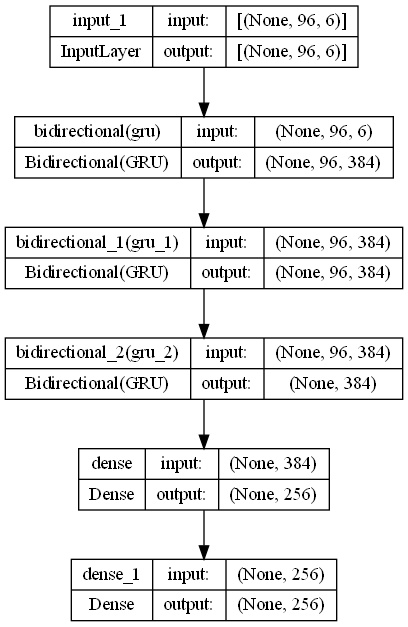

In [19]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

In [20]:
# compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
loss = 'categorical_crossentropy'
metrics = ['accuracy']

model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=metrics
)

In [21]:
# train model
history = model.fit(
    train_x, train_y_onehot,
    validation_data=(valid_x, valid_y_onehot),
    epochs=epochs,
    batch_size=batch_size,
    verbose=fit_verbose,
     callbacks=[model_checkpoint_callback],
)

Epoch 1/20
4082/4083 [============================>.] - ETA: 0s - loss: 5.3487 - accuracy: 0.0147
Epoch 1: val_loss improved from inf to 5.03290, saving model to .\best_model_epoch_01.h5
4083/4083 [==============================] - 244s 57ms/step - loss: 5.3487 - accuracy: 0.0147 - val_loss: 5.0329 - val_accuracy: 0.0379
Epoch 2/20
4082/4083 [============================>.] - ETA: 0s - loss: 4.8717 - accuracy: 0.0739
Epoch 2: val_loss improved from 5.03290 to 4.72886, saving model to .\best_model_epoch_02.h5
4083/4083 [==============================] - 230s 56ms/step - loss: 4.8717 - accuracy: 0.0739 - val_loss: 4.7289 - val_accuracy: 0.1095
Epoch 3/20
4082/4083 [============================>.] - ETA: 0s - loss: 4.6501 - accuracy: 0.1213
Epoch 3: val_loss improved from 4.72886 to 4.61694, saving model to .\best_model_epoch_03.h5
4083/4083 [==============================] - 230s 56ms/step - loss: 4.6501 - accuracy: 0.1213 - val_loss: 4.6169 - val_accuracy: 0.1277
Epoch 4/20
4082/4083 [=

## Draw training progress

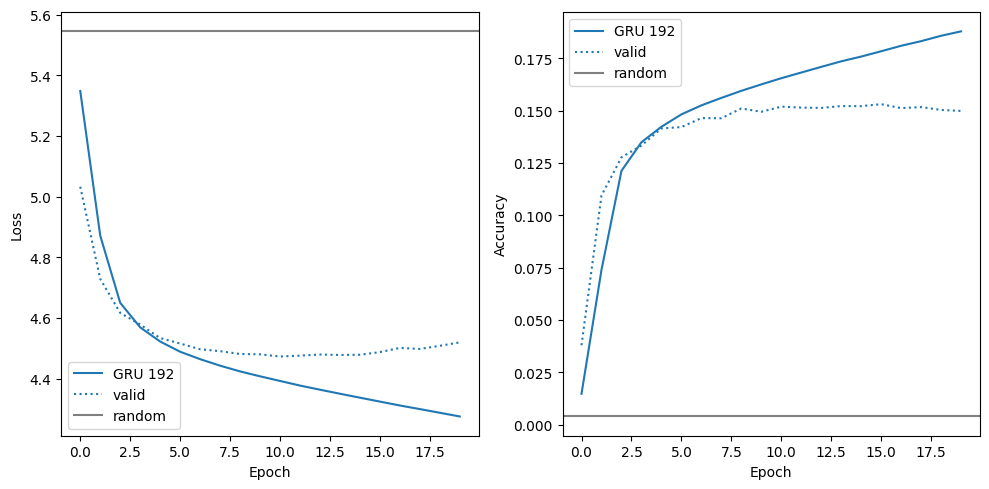

In [31]:
fig = plt.figure(figsize=(10, 5))

label = f"GRU {LSTM_width:d}"

# history - loss
ax = plt.subplot(121)
line = ax.plot(history.epoch, history.history['loss'], label=label)
ax.plot(history.epoch, history.history['val_loss'], linestyle="dotted", color=line[0].get_color(), label="valid")
ax.axhline(np.log(bin_num * bin_num), color="gray", label="random")

ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.legend()

# history - accuracy
ax = plt.subplot(122)
line = ax.plot(history.epoch, history.history['accuracy'], label=label)
ax.plot(history.epoch, history.history['val_accuracy'], linestyle="dotted", color=line[0].get_color(), label="valid")
ax.axhline(1 / bin_num / bin_num, color="gray", label="random")

ax.set_ylabel("Accuracy")
ax.set_xlabel("Epoch")
ax.legend()

plt.tight_layout()
plt.show()

# Load Model

In [23]:
import tensorflow as tf
from tensorflow.keras.models import load_model


In [24]:
model = load_model("best_model_epoch_11.h5")


## Evaluate model

In [25]:
valid_pred = model.predict(valid_x, verbose=1)

valid_pred_azimuth, valid_pred_zenith = pred_to_angle(valid_pred)

mae = angular_dist_score(valid_y[:, 0], valid_y[:, 1], valid_pred_azimuth, valid_pred_zenith)

3438/3438 [==============================] - 32s 9ms/step


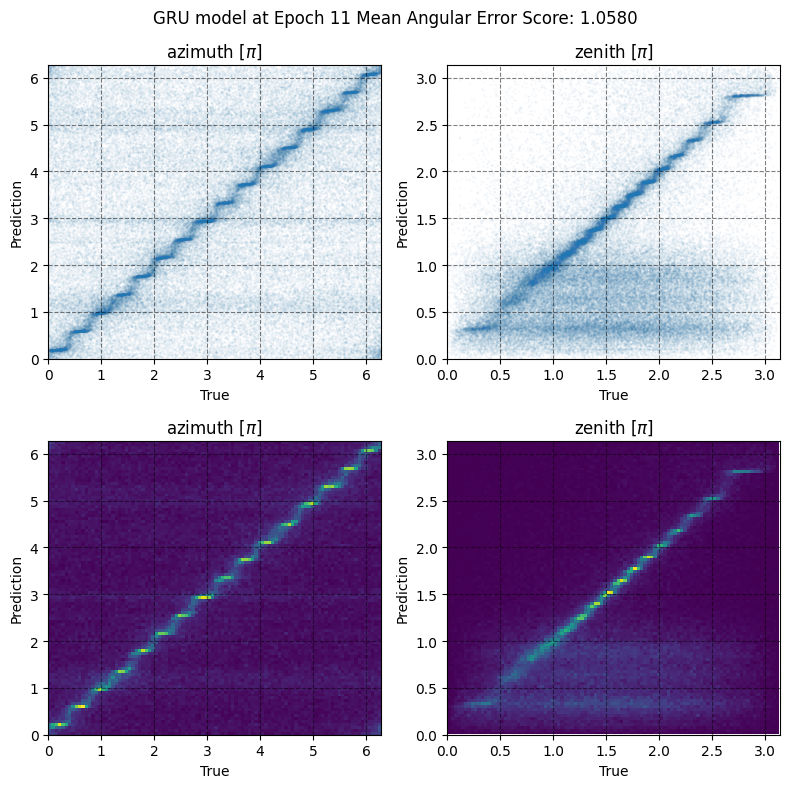

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

ax = axs[0, 0]
ax.scatter(valid_y[:, 0], valid_pred_azimuth, s=0.2, alpha=0.05)
ax.set_xlabel("True")
ax.set_ylabel("Prediction")
ax.set_xlim(0, 2 * np.pi)
ax.set_ylim(0, 2 * np.pi)
ax.grid(linestyle="dashed", color="black", alpha=0.5)
ax.set_title(r"azimuth [$\pi$]")

ax = axs[0, 1]
ax.scatter(valid_y[:, 1], valid_pred_zenith, s=0.2, alpha=0.05)
ax.set_xlabel("True")
ax.set_ylabel("Prediction")
ax.set_xlim(0, np.pi)
ax.set_ylim(0, np.pi)
ax.grid(linestyle="dashed", color="black", alpha=0.5)
ax.set_title(r"zenith [$\pi$]")

ax = axs[1, 0]
ax.hist2d(valid_y[:, 0], valid_pred_azimuth, bins=100)
ax.set_xlabel("True")
ax.set_ylabel("Prediction")
ax.set_xlim(0, 2 * np.pi)
ax.set_ylim(0, 2 * np.pi)
ax.grid(linestyle="dashed", color="black", alpha=0.5)
ax.set_title(r"azimuth [$\pi$]")

ax = axs[1, 1]
ax.hist2d(valid_y[:, 1], valid_pred_zenith, bins=100)
ax.set_xlabel("True")
ax.set_ylabel("Prediction")
ax.set_xlim(0, np.pi)
ax.set_ylim(0, np.pi)
ax.grid(linestyle="dashed", color="black", alpha=0.5)
ax.set_title(r"zenith [$\pi$]")

plt.suptitle(f"GRU model at Epoch 11 Mean Angular Error Score: {mae:.4f}")
plt.tight_layout()
plt.show()

In [27]:
from scipy.stats import pearsonr, spearmanr
correlation, p_value = pearsonr(valid_y[:, 0], valid_pred_azimuth)
print('Azimuth Correlation: ',correlation)

Azimuth Correlation:  0.29009548887535774


In [28]:
correlation, p_value = pearsonr(valid_y[:, 1], valid_pred_zenith)
print('Zenith Correlation: ',correlation)

Zenith Correlation:  0.36620625151161007


In [29]:
from sklearn.metrics import mean_absolute_error

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(valid_y[:, 0], valid_pred_azimuth)

# Print the MAE
print("Azimuth Mean Absolute Error (MAE):", mae)

Azimuth Mean Absolute Error (MAE): 1.4905880524691253


In [30]:
mae = mean_absolute_error(valid_y[:, 1], valid_pred_zenith)

# Print the MAE
print("Zenith Mean Absolute Error (MAE):", mae)

Zenith Mean Absolute Error (MAE): 0.6658827623593122
